# Introduction

Generative Adversarial Networks (GANs) are machine learning models for generating images, texts, sounds, etc. Training a GAN is a resource-intensive task. In this project, we explore the possibility of adding a multi-head attention layer to GAN. Unfortunately, we were not able to generate nice clear images, but we hope that researchers with access to higher processing power will be more successful with our approach. Generative Adversarial Nets is a generative AI model
which is capable of generating creative works through many modes such as image,
audio, etc. However, there are some limitations that are associated
with training GANS. Take for instance its inability to comprehend depth. When it comes to recognizing 3D objects, the GAN can sometimes
interpret it as a 2D structure and train it that way which would result
in poor-quality image generation. In 2017, an algorithm on Natural Language Processing  was
introduced in the machine learning community titled ”Attention Is All You
Need”. This paper introduced a transformer, an algorithm designed to process
data with context-like text-based data. Within the paper, they introduced
Multi-Headed Attention used to compare words
in a sentence and produce a probability score of how likely these words are
to come next to each other. What is interesting is that this is not only applicable
to text-based datasets but also image-based. In this notebook, I will be
talking about how multi-headed attention can be used in images to enhance the
performance of a GAN.

# Importing the libraries

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import os
from psutil import *
import time

### The loss function

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # This implies that a softmax function will be applied

# Proposed Architecture

While the current GAN is a very powerful algorithm that has many applications
in the creative arts space, I believe that it can further be improved to make it
more robust for handling multiple situations where the current GAN falls short, like for instance training on images with no constant background.
I propose a new algorithm, represented by *Figure 2* (in the annex) that would
enhance its depth perception improving its attention on important features.
As seen in the Multi-Headed Attention section of the notebook, the discriminator
will take images from the generator but also images from the data set that has
gone through the Multi-Headed attention process. The training will happen
as usual with these ”modified” images where the generator picks up on these
features more and more as the training progresses, improving the generator’s
ability to generate better images from noise. *Figure 5*
(in the annex) shows the images generated from my modified version (After Multi-headed Attention).

# Data-Preprocessing

## Converting the images to a matrix of vectors 

### Deriving the training set from normal images

The dataset used for the training of this algorithm is the **Flickr-Faces-HQ Dataset (FFHQ)** (Karras et al., 2018).

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
    )

# Converting the images to matrices
training_set = train_datagen.flow_from_directory("TrainingSet", target_size=(128, 128), color_mode="rgb", shuffle=True, batch_size=64)

### Deriving the training set from Multi-Headed Attended Images

Having images go through the Multi-Headed Attention function from Tensor-
Flow is a very computationally expensive task often taking up to **20 minutes**
to process a batch of 64 images. Therefore, to avoid the risk of overextended
training times, I simplified the process by having all the training images go
through the algorithm and save them separately into .npy files which can be
retrieved by the training file when training the algorithm. The code below demonstrates on how these files are extracted.

In [ ]:
def mha_dataset_assembler():

    returning_list = [] # The list to be returned

    for from_i in range(0, 100, 10):
        to_i = from_i+10 # Declaring the ending index
        # Initializing the name
        file_name = f"AttendedImagesDataset/AttendedImagesMatrixbatches{from_i}to{to_i}.npy"

        # Checking if the correct file names have been derived
        print(file_name)
        
        # Loading the dataset
        positionally_encoded_dataset = np.load(file_name, allow_pickle=True)

        # Appending to the list while avoiding the concatenate function
        for j in range(len(positionally_encoded_dataset)):
            returning_list.append(positionally_encoded_dataset[j])

    # Converting that list into an array
    returning_list = np.array(returning_list)

    # Returning the finalised list
    return returning_list

# Initializing the training_set
training_set = mha_dataset_assembler()

Displaying the shape of the training set:

In [ ]:
training_set.shape

(100, 64, 128, 128, 3)

# Multi-Headed Attention

## Multi-Headed Attention

Multi-Headed attention is a collection of scaled-dot product attention mechanisms
that are primarily used for text-based data but can be used for images
as well. While we won’t be able to go into how multi-headed attention works,
there are a few things to take note of why I use multi-headed attention for this
project. Namely, one of the most important aspects of multi-headed attention
is its ability to extract features within an image. Since multi-headed attention
is an elaborated dot product, it acts like a **filter** identifying features within the
image itself. Let’s say we have an image of a person. After running it through
the multi-headed attention algorithm, we will get an image as seen in *Figure 1*
(in the annex) with the colors representing the features that it had extracted!
Do note that the image will go through a **sigmoid operation** to convert the
matrix of pixels into weighted numbers ranging from 0 to 1.
This is a very useful feature for extracting the pixels that are necessary and
important for the training of the new GAN. As seen in *Figure 1* (in the annex),
the features that are not required will be deleted from the image, and this new
”filtered image” will be reduced by a factor of **0.1** and overlayed onto the original
image to give the extracted features “**more emphasis**” when running through
the discriminator. This will help the generator to train on those features more
and ignore the unnecessary features like the background of the image which
would hopefully achieve better results during the image generation process.

## Base-Attention Layer

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

## Global Self-Attention Layer

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x, 
        )
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

## Function to Apply Attention to Images

The function below returns a matrix of images that have been passed through the Multi-Headed Attention layer and deleted the pixels that were not relevant. After running it through
this function, we will get an image as seen in *Figure 1*
(in the annex) with the colors representing the features that it had extracted!

In [ ]:
def mha_on_images(original_image, num_heads):

  # Calling the multi-headed attention
  multi_headed_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=128)

  # Increasing the number of dimensions to generate the query, key and value
  processed_image = []

  for i in range(3):
    processed_image.append(image)

  processed_image = np.array(processed_image)

  # Applying the image into multi-headed attention
  attended_image = multi_headed_attention.call(processed_image)

  # Applying softmax into the image to ensure that the matrix of values are in between 0 and 1
  attended_image = tf.math.softmax(attended_image[0])

  # Getting the treshold value as to when to discard a pixel
  tolerance = np.mean(processed_image)

  # Looping through the image to remove the non-attended pixels

  processed_image = attended_image
  new_images = [] # Initialising a list for the new generated
  for row_index in range(len(processed_image)):
    list_of_rows = [] # A temporary list specifying what matrices need to be added
    for col_index in range(len(processed_image[row_index])):
      if (attended_image[row_index][col_index][0]<tolerance): # If the red value is less than tolerance
          a = np.array([0, 0, 0]) # Add zeros where the pixel value is not strong enough
          list_of_rows.append(tf.constant(a, dtype=tf.float32)) # Add everything but the color
      else:
          list_of_rows.append(original_image[row_index][col_index])
      
    new_images.append(list_of_rows)
  
  # Returning the images with the dead pixels and the attended image
  return new_images, attended_image, (np.array(new_images)*0.1+image) 


# Implementing the GAN

## Generative Adversarial Nets

In this section, I will be going through a brief explanation of how the GAN
works. Primarily, a typical GAN consists of 2 networks, the **Generator** and
the **Discriminator**. The generator is an **inverted convolutional neural
network** that is used to generate images based on noise. You can think of
noise as a matrix of randomly generated numbers. This 2D matrix represents
an image. The discriminator is a **standard convolutional neural network**
that takes 2 inputs, one from the generator and one from the training dataset
of the images, and tries to classify between the 2 using a sigmoid activation
function. The training of the GAN occurs in two steps:

1. The noise and an image of the training set are taken to compute the error
and update the weights of the discriminator.

2. The generator provides noise to the discriminator with which the discriminator
tries to classify. The error is computed and the weights of the
generator are updated.

The generator and discriminator participate in a minimax game trying to
compete with each other. The generator tries to fool the discriminator by generating
noise that looks like images from the training set while the discriminator
tries to differentiate between the “fake” images from the generator and the real
images from the dataset. Therefore, a balance is necessary. If the discriminator
is much more trained than the generator, the generator cannot train properly,
and vice versa. Below is the value function proposed by the Generative Adversarial
Nets paper:

---
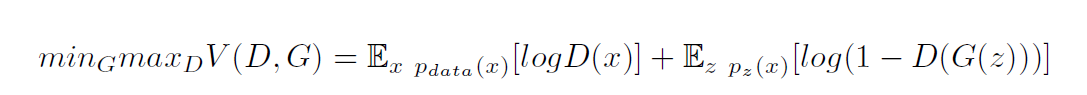

---



Which computes the expected probability that the image received by the
discriminator D(x) belongs to the real image data set added to the expected
probability that the image belongs to the real image data set when given noise
G(x). The generator will try to **minimize** this value while the discriminator will
try to **maximize** it. One indicator that we can use to determine if the algorithm
has reached global optimally, as suggested by the paper, is the equation below:

---
image.png

---

Where $p_{data}$ represents the probability distribution of the data set and $p_g$
represents the probability distribution of the images produced by the generator.
As the images produced by the generator become more similar to the images
from the data set, the above equation approaches **1/2** which would represent
global optimally.


## Implementing the Generator

Notice that by Layer 6 of the generator, an image of shape **(128, 128, 3)**
has been created which can be fed into the discriminator. The optimizer used
for the generator is the **Adam optimizer** and the loss function used was the
**Binary Cross-entropy** loss.

---
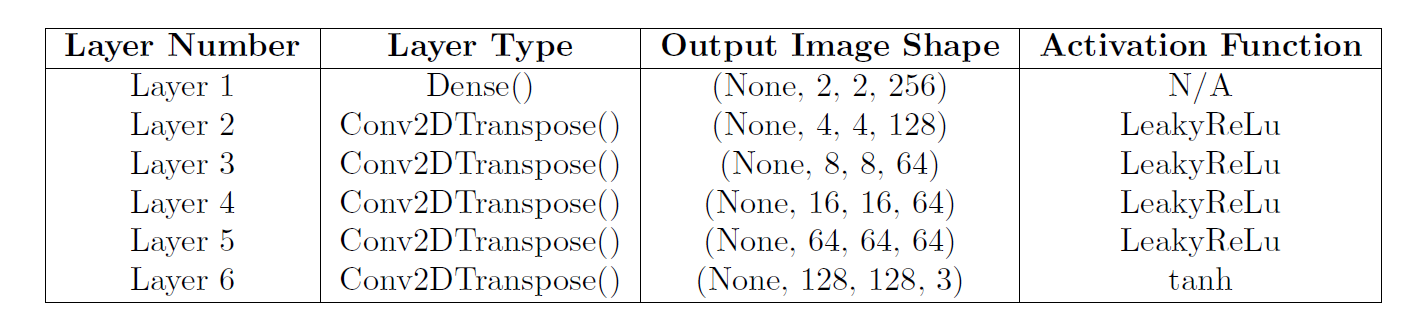


---


In [ ]:
def Generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(2*2*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((2, 2, 256)))
    assert model.output_shape == (None, 2, 2, 256) # Checking if the shape is kept to the desired one 

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 4, 4, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(4, 4), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

### The Generator Loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # Ones because the generator needs the variables to be ones to be trained

### What noise looks like

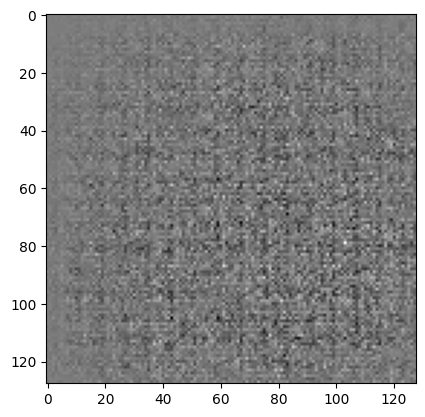

In [ ]:
generator = Generator()

def generate_noise():
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    return generated_image

# Displaying the noise
generated_image = generate_noise()
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Implementing the Discriminator

A **sigmoid** activation function is added to the discriminator through the
cross-entropy loss by setting the *from_logits=True* parameter. The optimizer
used for the discriminator is also the **Adam optimizer** and the loss function
used was the **Binary Cross-entropy** loss function.



---

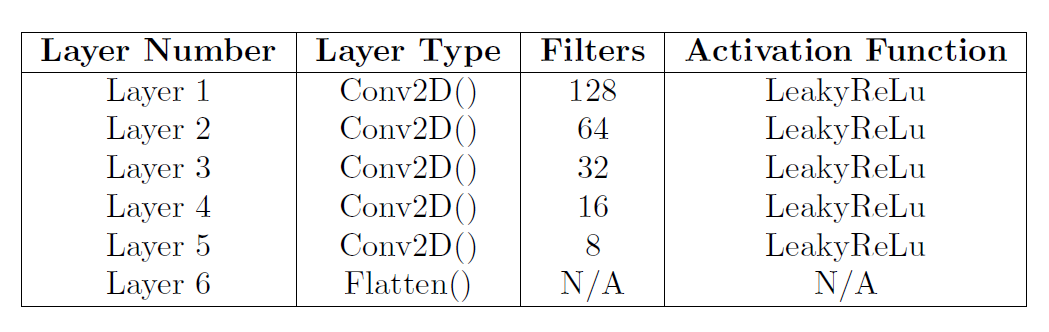

---





In [ ]:
def Discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(8, (2, 2), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1)) # Adding the sigmoid activation function to ensure values are between 1 and zero

    return model

In [ ]:
# Initializing the discriminator
discriminator = Discriminator()
decision = discriminator(generated_image)
decision # Checking if the function works

tf.Tensor([[6.710441e-06]], shape=(1, 1), dtype=float32)


### The Discriminator Loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Training the GAN

## Defining the optimizer

In [ ]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

## Defining the Check-points

In [ ]:
checkpoint_dir = './mha_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training the model:

### Getting the inputs

In [ ]:
num_of_epochs = int(input("Enter the number of epochs for training: "))
num_of_discriminator_training_instances = len(training_set)
minibatch_size = 64

In [ ]:
num_of_discriminator_training_instances = 100
print(f"The number of batches: {num_of_discriminator_training_instances}")

### Function to generate the image

In [ ]:
def display_img(gen):

    # Generating image from noise
    generated_image = gen(tf.random.normal([1, 100]), training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(generated_image.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_image[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')

### Function to generate & save the image

In [ ]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  # Generating the image and displaying it
  generated_image = model(tf.random.normal([1, 100]))
  plt.imshow(generated_image[0, :, :, :])


  plt.savefig('./MHA_images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Implementing the iterative training process

When it came to coding the algorithm, there were 2 possible options that I
could take, either choose the one provided by Google on their website or use
that as a template to modify into a much more suited version for the task. The
code provided by Google’s TensorFlow is used to train the MNIST data set and there was concern that this architecture would not have been enough to get good
results when it came to much more complicated data sets like faces. Therefore,
I had taken the code from TensorFlow’s website and used it to implement my
own version. I had trained **2 separate GANS**, one on my modified code, and
one that TensorFlow recommended. For a total of 560 epochs I trained the
GAN, recommended by TensorFlow, for 400 epochs and the next 160 with the modifications
that I had made. For the other GAN, I trained it on my appended version
for 560 epochs. I didn’t use the TensorFlow algorithm all the way through the
560 epochs due to the fact that there was still a slight hint of noise present in
the images generated and I noticed that the discriminator was not being trained
properly. *Figure 3* (in the annex) shows all the images trained by TensorFlow’s
algorithm while *Figure 4* (in the annex) shows all the images trained by my very
own modified version. It is important to note that while the images do not look
like a clear human face, I trained my GAN for sufficient epochs until which you
can see a clear distinction between a face with a background. I implemented the
algorithm using this framework due to the **lack of monetary funds**. Therefore,
the success of this experiment is solely based on whether **better images** can be
generated by the newly trained generator, on attended images, after 560 epochs.
Metrics based on the time taken to train the algorithm and the Θ(n) time and
complexity of the algorithm will not be taken into account but just whether
the images produced by the generator, trained on the Multi-Headed Attention
images, will generate a higher clarity face as compared to a generator that is
not.

---

#### **Tensorflow's Code**:



```
noise = tf.random.normal([minibatch_size, 100])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(training_set[batch_number][0], training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
```
---

#### **My Customised Version**:



```
  noise = tf.random.normal([minibatch_size, 100])

  # Printing the batch number
  print(f"Batch: {str((batch_number+1))}")

  # Training the discriminator twice
  for i in range(2):
    # Training the discriminator
    with tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=False)

      real_output = discriminator(training_set[batch_number][0], training=True)
      fake_output = discriminator(generated_images, training=True)

      # gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    # Adding the loss to the list
    list_of_discriminator_errors.append(disc_loss)

    # Updating the weights
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  # Training the generator
  noise = tf.random.normal([minibatch_size, 100]) # Recommended by Ian Goodfellow to generate a new set of noise for training the generator
  with tf.GradientTape() as gen_tape:

    generated_images = generator(noise, training=True)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

   

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  list_of_generator_errors.append(gradients_of_generator) # Adding the loss to the list
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
```

---







In [ ]:
@tf.function 
def train(batch_number, minibatch_size):

  # Initializing the noise
  noise = tf.random.normal([minibatch_size, 100])

  # Training the discriminator twice
  for i in range(2):
    # Training the discriminator
    with tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=False)

      # real_output = discriminator(training_set[batch_number][0], training=True) # This is for the original images form the initial dataset with no Multi-Headed Attention
      real_output = discriminator(training_set[batch_number], training=True) # This is for the attended images
      fake_output = discriminator(generated_images, training=True)

      # gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    # Adding the loss to the list
    list_of_discriminator_errors.append(disc_loss)

    # Updating the weights
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  # Training the generator
  noise = tf.random.normal([minibatch_size, 100]) # Recommended by Ian Goodfellow to generate a new set of noise for training the generator
  with tf.GradientTape() as gen_tape:

    generated_images = generator(noise, training=True)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

   

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  list_of_generator_errors.append(gradients_of_generator) # Adding the loss to the list
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  

# Getting the starting point of the training iterations
start_time = time.time()

# Restoring the Checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Training through the epochs and batches
for i in range(num_of_epochs):
  print(f"Epoch: {str((i+1))}/{str(num_of_epochs)}")
  for k in range(num_of_discriminator_training_instances):
    print(f"    Batch: {str((k+1))}/{str(num_of_discriminator_training_instances)}")
    train(k, minibatch_size)
  
  # Saving the images if epochs is divisible by 20 or 0
  if ((i%20 == 0) or (i==0)):
    generate_and_save_images(generator, (i+1), tf.random.normal([1, 100]))
    checkpoint.save(file_prefix = checkpoint_prefix) # Saving the checkpoint
      
# Getting the ending time
end_time = time.time()

# Results

## Google's Code

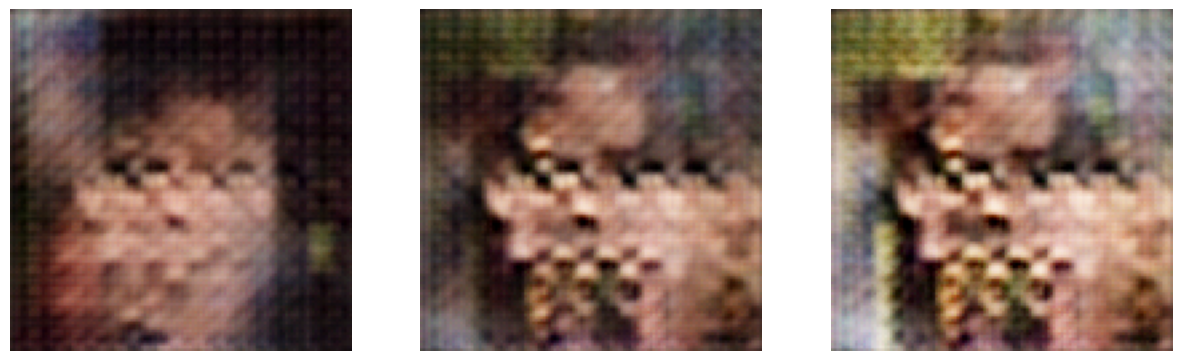

In [ ]:
generate_images(3, generator, './training_checkpoints') # Getting the weights saved from the file "./training_checkpoints"

## My customised version

In [ ]:
generate_images(3, generator, './custom_version_training_checkpoints') # Getting the weights saved from the file "./custom_version_training_checkpoints"

## My Code with **Multi-Headed Attention**

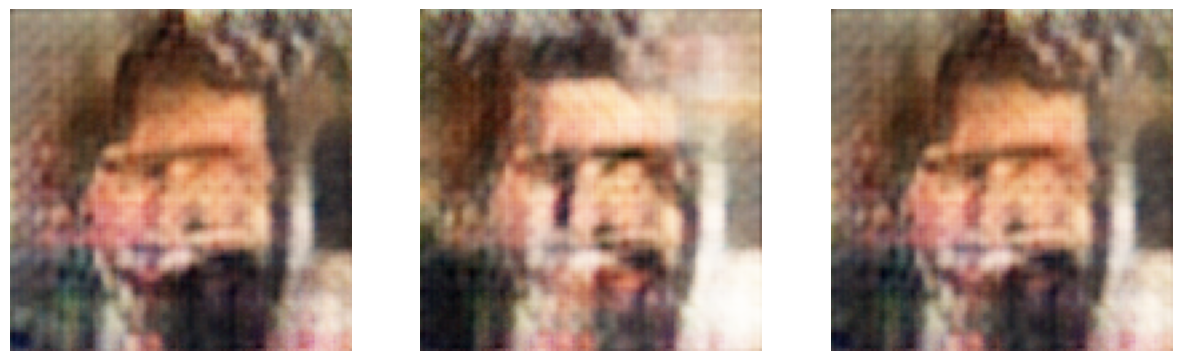

In [ ]:
generate_images(3, generator, './mha_training_checkpoints') # Getting the weights saved from the file "./mha_training_checkpoints"

# Conclusion

In conclusion, while Multi-Headed attention does help in extracting the features
from an image, it does not improve the Generative Adversarial Net environment
as a whole, and due to the **extra costs required to add the Multi-Headed
Attention node** into the overall framework, the cost to benefit ratio of this
algorithm fails to meet the standards established by the original GAN. That
being said, I do feel like it is worth running this algorithm for more than 560
epochs, to get a much more definitive conclusion, since it is a major factor when
it comes to comparing performance.

# Annex

## Figure 1

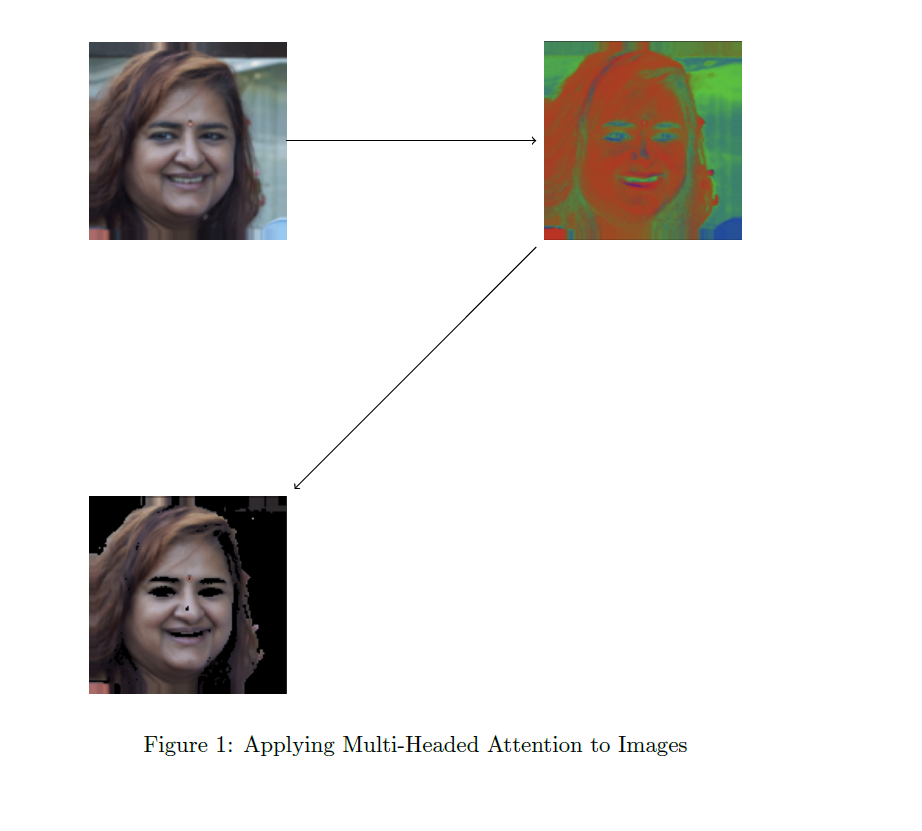

## Figure 2

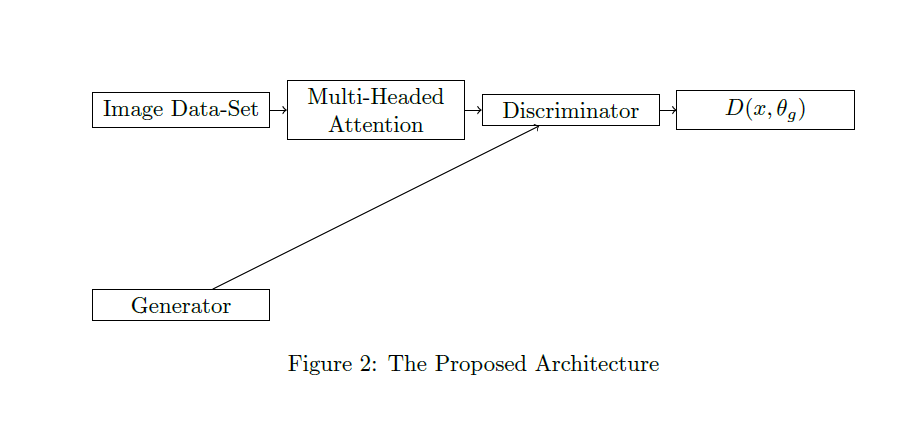

## Figure 3

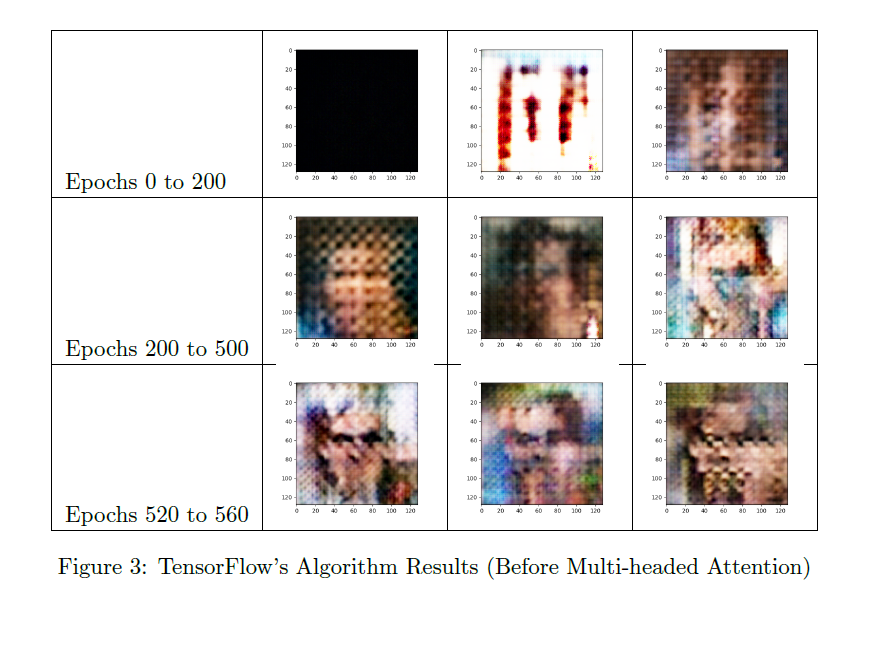

## Figure 4

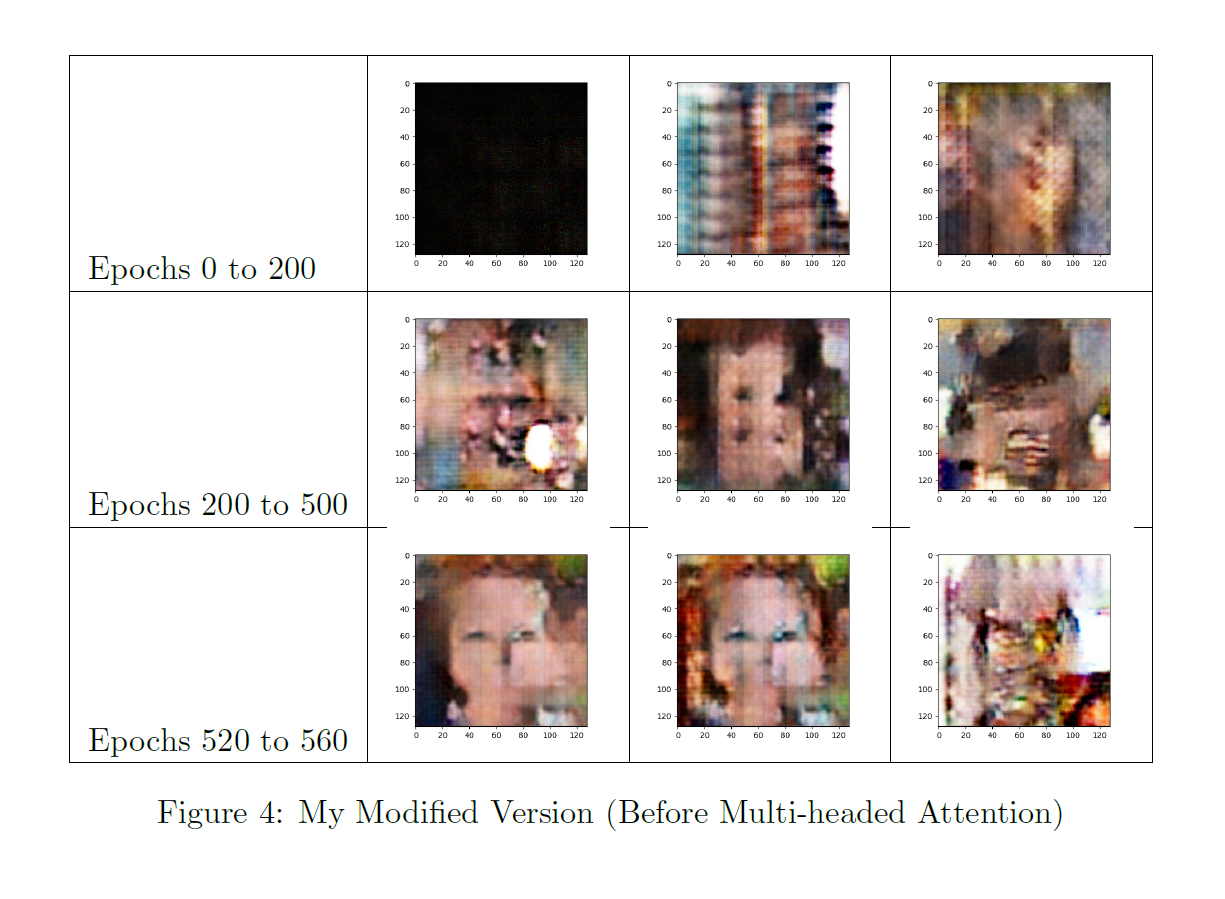

## Figure 5

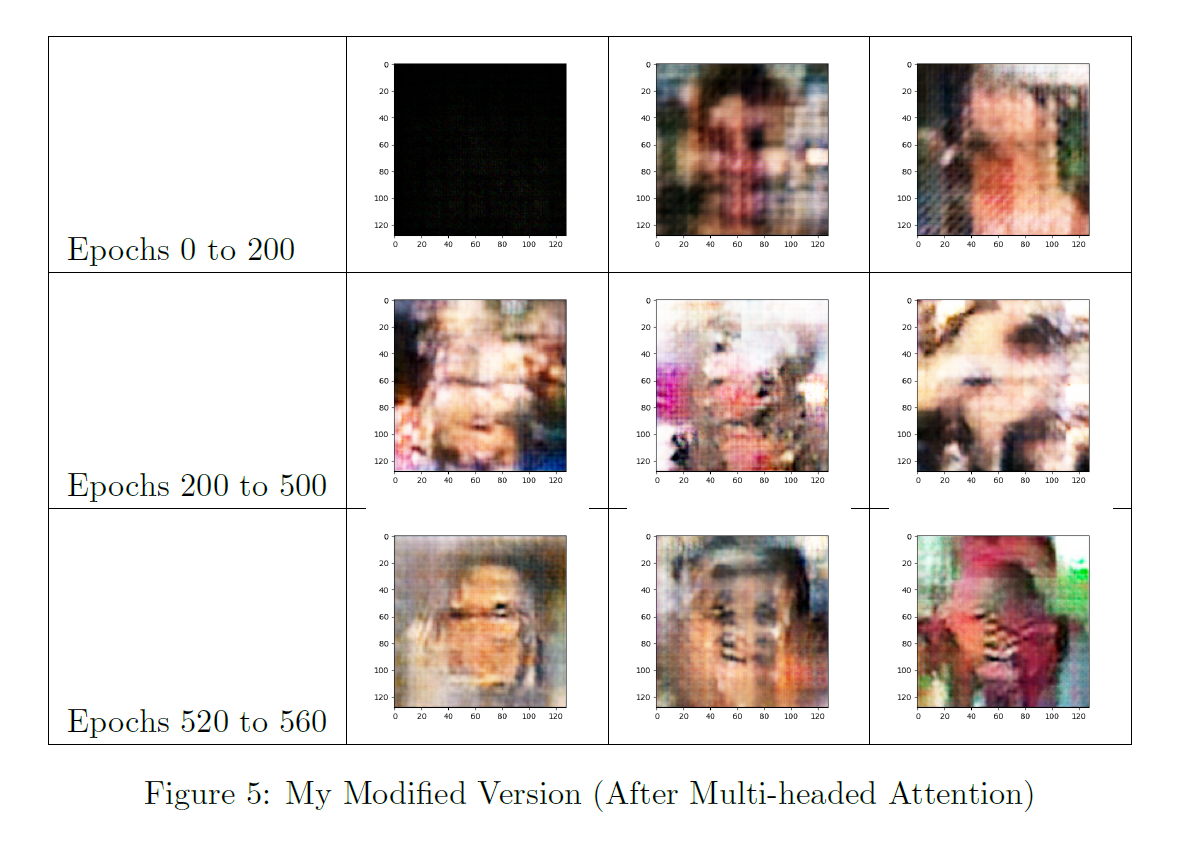

# References:


## Introductory guide to Generative Adversarial Networks (GANs) and their promise! :
https://www.analyticsvidhya.com/blog/2017/06/introductory-generative-adversarial-networks-gans/

##  Applications of GANs:

https://www.udemy.com/course/computer-vision-a-z/learn/lecture/8226356#overview

**Note: (Time: 4:13)**

## Dataset:

https://github.com/NVlabs/ffhq-dataset

**Note: This dataset was modified through the Multi-Headed Attention Layer for training the GAN**.

**Citation**:

Karras, T., Laine, S., & Aila, T. (2018). A Style-Based Generator Architecture for Generative Adversarial Networks. *2019 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)*, 4396-4405.

## Neural machine translation with a Transformer and Keras:

https://www.tensorflow.org/text/tutorials/transformer

**Note: This code was modified in this notebook slightly**.

## Visual Guide to Transformer Neural Networks - (Episode 2) Multi-Head & Self-Attention:

https://www.youtube.com/watch?v=mMa2PmYJlCo

**Note: (Time: 14:06)**

## Attention Is All You Need:
https://arxiv.org/pdf/1706.03762.pdf

## Deep Convolutional Generative Adversarial Network:

https://www.tensorflow.org/tutorials/generative/dcgan

**Note: This code was modified in this notebook by using snippets of it to adapt to my modified version**.

## Generative Adversarial Nets:

https://arxiv.org/pdf/1406.2661.pdf